# Running Canonical Monte Carlo Simulated Annealing on an Ewald Hamiltonian
When generating a set of structures to sample, it may be useful to enumerate them through a Monte Carlo simulation. An MC with only Ewald electrostatic energies can be especially useful for the initial training set, when there are no DFT energies to parametrize a cluster expansion and run MC. 

In [22]:
import copy

import numpy as np
import matplotlib.pyplot as plt
from monty.serialization import loadfn, dumpfn
from pymatgen.analysis.ewald import EwaldSummation
from pymatgen.core import Structure
from smol.cofe import ClusterSubspace
from smol.io import load_work, save_work
from smol.cofe.extern import EwaldTerm

### (0) Create a Cluster Subspace based on the disordered structure with only the empty cluster and Ewald term

In [23]:
lno = loadfn('data/lno_prim.json') 
lno

Structure Summary
Lattice
    abc : 2.969848 2.9698481608006304 5.143928079443783
 angles : 73.22134967468278 73.22134665054797 60.00000177324646
 volume : 37.04398870365559
      A : 2.843413003724563 -0.0 0.8573211961418291
      B : 1.5509524920968607 -2.532695099191652 1.046778248525726e-07
      C : 2.843413003724563 -0.0 -4.2866068838581715
PeriodicSite: Li+:0.500 (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Ni3+:0.500, Ni4+:0.500 (3.6189, -1.2663, -1.7146) [0.5000, 0.5000, 0.5000]
PeriodicSite: O2- (5.4283, -1.8995, -2.5720) [0.7500, 0.7500, 0.7500]
PeriodicSite: O2- (1.8094, -0.6332, -0.8573) [0.2500, 0.2500, 0.2500]

In [24]:
empty_cutoff = {} # Defining the cut-offs as an empty dictionary will generate a subspace with only the empty cluster

subspace = ClusterSubspace.from_cutoffs(structure=lno, 
                                        cutoffs=empty_cutoff, 
                                        basis='sinusoid',
                                        supercell_size='O2-')

subspace.add_external_term(EwaldTerm(eta=None)) # Add the external Ewald Term

### (1) Create an Ewald Processor
An Ewald Processor handles changes in electrostatic interaction energies among different configurational states, using an Ewald Summation term.

In [25]:
from smol.moca import EwaldProcessor

In [26]:
# The supercell with which we will run MC on
sc_matrix = np.array([[4, 0, 0],
                      [0, 4, 0],
                      [0, 0, 2]])

# Specifying the dielectric constant, the inverse of which is parametrized when fitting a CE with electrostatics (Example 1-1). 
dielectric = 5 

# Creating the Ewald Processor
ewald_proc = EwaldProcessor(cluster_subspace=subspace,
                            supercell_matrix=sc_matrix,
                            ewald_term=EwaldTerm(),
                            ewald_summation=None, # A default EwaldSummation from Pymatgen will be used
                            coefficient=1/dielectric)

### (2) Create a Canonical Ensemble

In [27]:
from smol.moca import CanonicalEnsemble

# Create the canonical ensemble directly from the Ewald Processor, without creating a Cluster Expansion.
ensemble = CanonicalEnsemble(processor=ewald_proc)

# If the goal is to enumerate new structures for DFT calculations, it may be wise to limit the size of
# your supercell such that a relaxation calculation is feasible.
# The thermodynamics may not be the most realistic, but you can generate training structures
# that have relatively low electrostatic energies, which may translate to lower DFT energies.
print(f'The supercell size for the processor is {ensemble.processor.size} prims.')
print(f'The ensemble has a total of {ensemble.num_sites} sites.')
print(f'The active sublattices are:')
for sublattice in ensemble.sublattices:
    print(sublattice)

The supercell size for the processor is 32 prims.
The ensemble has a total of 128 sites.
The active sublattices are:
Sublattice(site_space=SiteSpace: Ni1, sites=array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), active_sites=array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]))
Sublattice(site_space=SiteSpace: Li0.5, sites=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]), active_sites=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]))


### (3) Create the Sampler

In [28]:
from smol.moca import Sampler

sampler = Sampler.from_ensemble(ensemble, temperature=10000)
print(f"Sampling information: {sampler.samples.metadata}")

Sampling information: {'name': 'CanonicalEnsemble', 'kernel': 'Metropolis', 'step': 'swap', 'seed': 12361178774271775972}


### (4) Generate an initial ordered structure to start the MC simulation.

In [29]:
from pymatgen.transformations.standard_transformations import OrderDisorderedStructureTransformation

# Here we will just use the order disordered transformation from
# pymatgen to get an ordered version of a prim supercell.
# The structure will have the same composition set in the prim.
transformation = OrderDisorderedStructureTransformation(algo=2)

supercell = lno.copy()
supercell.make_supercell(sc_matrix)

test_struct = transformation.apply_transformation(supercell)
print(test_struct.composition)

Li+16 Ni3+16 Ni4+16 O2-64


In [30]:
# Obtain the initial occupancy string from the
# test structure created above.
init_occu = ensemble.processor.occupancy_from_structure(test_struct)

# The occupancy strings created by the processor
# are by default "encoded" by the indices of the species
# for each given site. You can always see the actual
# species in the occupancy string by decoding it.
print(f'The encoded occupancy is:\n{init_occu}')
print(f'The initial occupancy is:\n {ensemble.processor.decode_occupancy(init_occu)}')

The encoded occupancy is:
[0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1
 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
The initial occupancy is:
 [Species Li+, Species Li+, Vacancy vacA0+, Vacancy vacA0+, Species Li+, Species Li+, Vacancy vacA0+, Vacancy vacA0+, Vacancy vacA0+, Vacancy vacA0+, Species Li+, Species Li+, Vacancy vacA0+, Vacancy vacA0+, Species Li+, Species Li+, Species Li+, Species Li+, Vacancy vacA0+, Vacancy vacA0+, Species Li+, Species Li+, Vacancy vacA0+, Vacancy vacA0+, Vacancy vacA0+, Vacancy vacA0+, Species Li+, Species Li+, Vacancy vacA0+, Vacancy vacA0+, Species Li+, Species Li+, Species Ni4+, Species Ni4+, Species Ni3+, Species Ni3+, Species Ni4+, Species Ni4+, Species Ni3+, Species Ni3+, Species Ni3+, Species Ni3+, Species Ni4+, Species Ni4+, Species Ni3+, Species Ni3+, Species Ni4+, Species Ni4

### (5) Run MC simulated annealing

In [31]:
# Setting up the range of temperatures for simulated annealing. We start at very 
# high temperatures to approach the random limit. At each temperature, a MC simulation is performed. 
# At the lowest temperatures, you may find that you converge to a ground state.
temps = np.logspace(4, 2, 10)

mc_steps = 100000 # Defining number of MC steps at each temperature
n_thin_by = 10 # Number to thin by

# Start simulated annealing.
sampler.anneal(temperatures=temps, 
               mcmc_steps=mc_steps,
               initial_occupancies=init_occu,
               thin_by=n_thin_by, # Saving every 10 samples
               progress=True # Show the progress bar to know how far along you are
              )

Sampling 1 chain(s) from a cell with 128 sites...: 100%|██████████████████████| 100000/100000 [00:03<00:00, 26264.37it/s]
Sampling 1 chain(s) from a cell with 128 sites...: 100%|██████████████████████| 100000/100000 [00:03<00:00, 26853.85it/s]
Sampling 1 chain(s) from a cell with 128 sites...: 100%|██████████████████████| 100000/100000 [00:03<00:00, 27782.63it/s]
Sampling 1 chain(s) from a cell with 128 sites...: 100%|██████████████████████| 100000/100000 [00:03<00:00, 28967.39it/s]
Sampling 1 chain(s) from a cell with 128 sites...: 100%|██████████████████████| 100000/100000 [00:03<00:00, 30013.93it/s]
Sampling 1 chain(s) from a cell with 128 sites...: 100%|██████████████████████| 100000/100000 [00:03<00:00, 32018.36it/s]
Sampling 1 chain(s) from a cell with 128 sites...: 100%|██████████████████████| 100000/100000 [00:03<00:00, 31551.30it/s]
Sampling 1 chain(s) from a cell with 128 sites...: 100%|██████████████████████| 100000/100000 [00:03<00:00, 31704.70it/s]
Sampling 1 chain(s) from

### (6) Analyzing MC sampling at each temperature

In [54]:
n = int(mc_steps/10) # number of samples saved for the MC at each temperature
energies = sampler.samples.get_energies()
mc_temps = list() # Create list of temperatures that correspond to the energies

for t in temps:
    mc_temps.extend([t for i in range(n)]) 

In [93]:
# Obtain the average and standard deviation of energy at each temperature.
for t in temps:
    plot_inds = np.where(mc_temps == t)[0]
    energies_t = np.array([energies[ind] for ind in plot_inds]) / ewald_proc.size
    avg_en = round(np.average(energies_t), 3)
    std_en = round(np.std(energies_t), 4)
    print(f'At T = {round(t, 2)} K \nAverage energy = {avg_en} eV/prim \nStd dev = {std_en} eV/prim \n')

At T = 10000.0 K 
Average energy = -22.113 eV/prim 
Std dev = 0.0312 eV/prim 

At T = 5994.84 K 
Average energy = -22.133 eV/prim 
Std dev = 0.026 eV/prim 

At T = 3593.81 K 
Average energy = -22.155 eV/prim 
Std dev = 0.0201 eV/prim 

At T = 2154.43 K 
Average energy = -22.176 eV/prim 
Std dev = 0.0153 eV/prim 

At T = 1291.55 K 
Average energy = -22.197 eV/prim 
Std dev = 0.0118 eV/prim 

At T = 774.26 K 
Average energy = -22.262 eV/prim 
Std dev = 0.0132 eV/prim 

At T = 464.16 K 
Average energy = -22.266 eV/prim 
Std dev = 0.0 eV/prim 

At T = 278.26 K 
Average energy = -22.266 eV/prim 
Std dev = 0.0 eV/prim 

At T = 166.81 K 
Average energy = -22.266 eV/prim 
Std dev = 0.0 eV/prim 

At T = 100.0 K 
Average energy = -22.266 eV/prim 
Std dev = 0.0 eV/prim 



#### Obtaining the ground state

In [89]:
lowest_en = sampler.samples.get_minimum_energy() / ewald_proc.size
lowest_en_occu = sampler.samples.get_minimum_energy_occupancy()

print(f'The ground state energy is {lowest_en} eV/prim')
print(f'Ground state occupancy is {lowest_en_occu}')

The ground state energy is -22.2657575304729 eV/prim
Ground state occupancy is [1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0
 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### (7) Plotting the results

(array([-22.3 , -22.25, -22.2 , -22.15, -22.1 , -22.05, -22.  , -21.95,
        -21.9 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

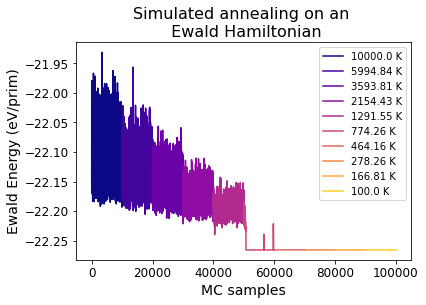

In [95]:
x_ind = 0 # To keep track of x axis indexing

for i, t in enumerate(temps):
    plot_inds = np.where(mc_temps == t)[0]
    energies_t = np.array([energies[ind] for ind in plot_inds]) / ewald_proc.size # Obtain normalized energies at this temperature
    col = plt.cm.plasma(i/len(temps)) # Set the color
    num_samples = len(energies_t) 
    plt.plot(np.arange(x_ind, x_ind + num_samples), energies_t, color=col,   
             label=f'{round(t, 2)} K')
    x_ind += num_samples
    
plt.legend()
plt.title('Simulated annealing on an \n Ewald Hamiltonian', fontsize=16)
plt.ylabel('Ewald Energy (eV/prim)', fontsize=14)
plt.xlabel('MC samples', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)